In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical

print(f"TF Version: {tf.__version__}")

TF Version: 2.8.2


In [ ]:
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"],
    batch_size=-1,
    as_supervised=True,
)

In [ ]:
train_ds.shape

TensorShape([2569, 442, 1024, 3])

In [ ]:
test_ds.shape

TensorShape([1101, 442, 1024, 3])

In [ ]:
test_labels

<tf.Tensor: shape=(1101,), dtype=int64, numpy=array([2, 3, 3, ..., 2, 4, 2])>

In [ ]:
size = (150, 150)

train_ds = tf.image.resize(train_ds, size)
test_ds = tf.image.resize(test_ds, size)

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
hand_model = Sequential()

hand_model.add(Rescaling(1.0 / 255, input_shape=(150, 150, 3)))

hand_model.add(layers.Conv2D(16, kernel_size=10, activation="relu"))
hand_model.add(layers.MaxPooling2D(3))

hand_model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
hand_model.add(layers.MaxPooling2D(2))

hand_model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
hand_model.add(layers.MaxPooling2D(2))

hand_model.add(layers.Flatten())
hand_model.add(layers.Dense(50, activation="relu"))
hand_model.add(layers.Dense(20, activation="relu"))
hand_model.add(layers.Dense(5, activation="softmax"))

hand_model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

es = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

with tf.device("/device:GPU:0"):
    hand_model.fit(
        train_ds,
        train_labels,
        epochs=50,
        validation_split=0.2,
        batch_size=32,
        callbacks=[es],
    )

Epoch 1/50
65/65 [==============================] - 2s 26ms/step - loss: 1.5701 - accuracy: 0.2827 - val_loss: 1.5478 - val_accuracy: 0.3054
Epoch 2/50
65/65 [==============================] - 1s 21ms/step - loss: 1.4761 - accuracy: 0.3509 - val_loss: 1.4149 - val_accuracy: 0.3852
Epoch 3/50
65/65 [==============================] - 1s 21ms/step - loss: 1.3636 - accuracy: 0.3917 - val_loss: 1.3420 - val_accuracy: 0.4047
Epoch 4/50
65/65 [==============================] - 1s 21ms/step - loss: 1.2927 - accuracy: 0.4564 - val_loss: 1.2987 - val_accuracy: 0.4689
Epoch 5/50
65/65 [==============================] - 1s 21ms/step - loss: 1.2853 - accuracy: 0.4516 - val_loss: 1.2051 - val_accuracy: 0.5039
Epoch 6/50
65/65 [==============================] - 1s 21ms/step - loss: 1.2064 - accuracy: 0.4905 - val_loss: 1.2049 - val_accuracy: 0.5117
Epoch 7/50
65/65 [==============================] - 1s 20ms/step - loss: 1.1785 - accuracy: 0.5002 - val_loss: 1.2027 - val_accuracy: 0.4942
Epoch 8/50
65

In [ ]:
loss, acc = hand_model.evaluate(test_ds, test_labels)

print(f"A loss do modelo é {loss:.2f}, e a ACC é {acc:.2f}")

35/35 [==============================] - 0s 12ms/step - loss: 0.7709 - accuracy: 0.7266
A loss do modelo é 0.77, e a ACC é 0.73


In [ ]:
hand_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 141, 141, 16)      4816      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        32800     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 15, 32)       

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm


def plot_matriz(y_test, y_pred):
    labels = list(map(np.argmax, y_test))
    labels_pred = list(map(np.argmax, y_pred))

    matrix = cm(labels, labels_pred)
    sns.heatmap(matrix, annot=True);

In [ ]:
preds = hand_model.predict(test_ds)

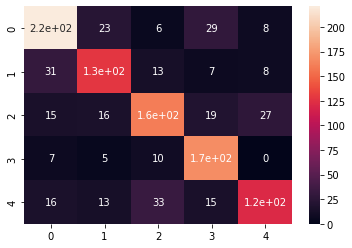

In [ ]:
plot_matriz(test_labels, preds)  # 2.6e+02 = 2.6x10² == 260

In [ ]:
# transfer

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(50, activation="relu")
dense_layer2 = layers.Dense(20, activation="relu")
prediction_layer = layers.Dense(5, activation="softmax")

In [ ]:
model = models.Sequential(
    [base_model, flatten_layer, dense_layer, dense_layer2, prediction_layer]
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 50)                409650    
                                                                 
 dense_10 (Dense)            (None, 20)                1020      
                                                                 
 dense_11 (Dense)            (None, 5)                 105       
                                                                 
Total params: 15,125,463
Trainable params: 410,775
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping as es

In [ ]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
es = es(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True)

In [ ]:
model.fit(
    train_ds,
    train_labels,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es],
)

Epoch 1/50
65/65 [==============================] - 8s 105ms/step - loss: 1.5939 - accuracy: 0.4769 - val_loss: 1.1037 - val_accuracy: 0.5584
Epoch 2/50
65/65 [==============================] - 6s 100ms/step - loss: 0.8374 - accuracy: 0.6779 - val_loss: 1.0055 - val_accuracy: 0.6206
Epoch 3/50
65/65 [==============================] - 7s 103ms/step - loss: 0.5627 - accuracy: 0.7810 - val_loss: 0.9397 - val_accuracy: 0.6693
Epoch 4/50
65/65 [==============================] - 7s 101ms/step - loss: 0.4295 - accuracy: 0.8448 - val_loss: 0.9792 - val_accuracy: 0.6790
Epoch 5/50
65/65 [==============================] - 7s 101ms/step - loss: 0.2785 - accuracy: 0.9012 - val_loss: 1.0848 - val_accuracy: 0.6887
Epoch 6/50
65/65 [==============================] - 6s 100ms/step - loss: 0.1923 - accuracy: 0.9343 - val_loss: 1.0484 - val_accuracy: 0.7121
Epoch 7/50
65/65 [==============================] - 6s 99ms/step - loss: 0.1152 - accuracy: 0.9640 - val_loss: 1.2899 - val_accuracy: 0.7004
Epoch 8

In [ ]:
loss, acc = model.evaluate(test_ds, test_labels)

print(f"A loss do modelo é {loss:.2f}, e a ACC é {acc:.2f}")

35/35 [==============================] - 3s 77ms/step - loss: 0.0057 - accuracy: 0.9991
A loss do modelo é 0.01, e a ACC é 1.00


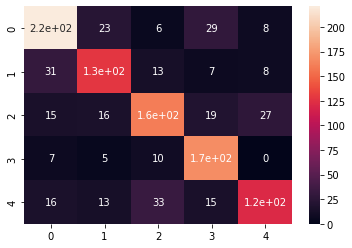

In [ ]:
plot_matriz(test_labels, preds)